In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import galah_li_rich_selection
import getpass
import mpl_scatter_density
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import h5py
import os
username = getpass.getuser()

%config InlineBackend.figure_format = 'retina'

In [2]:
galah_idr3, galah_idr3_position = galah_li_rich_selection.load_table(f"/Users/{username}/ownCloud/unique_GALAH_iDR3_1912_with_RC.fits")



In [7]:
(ignore_stars_idx, good_spec_idx,
 giant_idx, li_measured_idx, li_rich_idx) = galah_li_rich_selection.create_selections(galah_idr3, galah_idr3_position)

useful_stars_idx = ~ignore_stars_idx & good_spec_idx
useful_giants_idx = useful_stars_idx & giant_idx
useful_li_giants_idx = useful_giants_idx & li_measured_idx
useful_li_rich_giants_idx = useful_li_giants_idx & li_rich_idx
useful_super_li_rich_giants_idx = useful_li_giants_idx & (galah_idr3['a_li'] > 2.7)

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [8]:
# This doesn't include 
super_li = 2.7
total_size = 567122
useful_stars_idx = ~ignore_stars_idx & good_spec_idx
useful_giants_idx = useful_stars_idx & giant_idx
useful_li_giants_idx = useful_giants_idx & li_measured_idx
useful_li_rich_giants_idx = useful_li_giants_idx & li_rich_idx
useful_super_li_rich_giants_idx = useful_li_giants_idx & (galah_idr3['a_li'] > super_li)
k2_fields = (galah_idr3['field_id'] > 6540) & (galah_idr3['field_id']< 6831)
tess_fields = (galah_idr3['field_id'] > 7080) & (galah_idr3['field_id']< 7364)

print(f"This retained {100*np.sum(useful_stars_idx)/total_size:0.1f} per cent ({np.sum(useful_stars_idx)}/{total_size}) of the sample.")
# 
print(f"{100*np.sum(useful_giants_idx)/np.sum(useful_stars_idx):0.1f} per cent ({np.sum(useful_giants_idx)}/{np.sum(useful_stars_idx)}) of our sample of ``good'' stars were identified as giant stars.")

print(f"Of these {np.sum(useful_giants_idx)} giant stars, only {np.sum(useful_li_giants_idx)} ({100*np.sum(useful_li_giants_idx)/np.sum(useful_giants_idx):0.1f} per cent) had a measured \\ali. ")

print(f"Our red giant data set contains {np.sum(useful_li_rich_giants_idx)} stars with $\\ali> 1.5$")

print(f"Of those, {np.sum(useful_super_li_rich_giants_idx)} stars lie above the primordial value (WMAP reference?) of $\\ali> {super_li}$")

print(f"If we consider just the K2-HERMES fields: {np.sum(k2_fields & useful_giants_idx)}/{np.sum(k2_fields & useful_li_rich_giants_idx)}/{np.sum(k2_fields & useful_super_li_rich_giants_idx)}")
print(f"If we consider just the TESS-HERMES fields: {np.sum(tess_fields & useful_giants_idx)}/{np.sum(tess_fields & useful_li_rich_giants_idx)}/{np.sum(tess_fields & useful_super_li_rich_giants_idx)}")


This retained 75.2 per cent (426541/567122) of the sample.
31.0 per cent (132076/426541) of our sample of ``good'' stars were identified as giant stars.
Of these 132076 giant stars, only 13237 (10.0 per cent) had a measured \ali. 
Our red giant data set contains 1551 stars with $\ali> 1.5$
Of those, 392 stars lie above the primordial value (WMAP reference?) of $\ali> 2.7$
If we consider just the K2-HERMES fields: 20077/239/59
If we consider just the TESS-HERMES fields: 7329/84/20


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [32]:
def load_spectrum(star, camera):
    sobject_id = str(star['sobject_id'])
    date = str(sobject_id[:6])
    com = "com"
    if sobject_id[11] == "2":
        com += "2"
    fits_dir = f"/Users/{username}/ownCloud/GALAH_hdf5/obs/reductions/Iraf_5.3/{date}"
    hdf5_path = f"{fits_dir}/{date}_{com}.hdf5"
    specfile = f"{fits_dir}/{com}/{sobject_id}{camera}.fits"
    
    if os.path.exists(hdf5_path):
        try:
            with h5py.File(hdf5_path, 'r') as f:
#                 print(sobject_id, "H5PY")
                h5py_str = f'{sobject_id}/{camera}/normed'
                flux = f[h5py_str]['spectrum'][()]
                CDELT1 = f[h5py_str].attrs['CDELT1']
                CRVAL1 = f[h5py_str].attrs['CRVAL1']
                CRPIX1 = f[h5py_str].attrs['CRPIX1']
                wavelength = (CDELT1 * (np.arange(len(flux)) + 1 - CRPIX1) + CRVAL1)
            return wavelength, flux
        except OSError:
            print(f"OSError on {hdf5_path}")
            pass
        except KeyError:
            print(f"KeyError on {hdf5_path}")
            pass
    if os.path.exists(specfile):
        with fits.open(specfile) as spec:
            print(sobject_id, "FITS")
            flux = spec[4].data
            CDELT1 = spec[0].header['CDELT1']
            CRVAL1 = spec[0].header['CRVAL1']
            CRPIX1 = spec[0].header['CRPIX1']
            wavelength = (CDELT1 * (np.arange(len(flux)) + 1 - CRPIX1) + CRVAL1)
            v_t = star['rv_guess'] * u.km / u.s 
            v_b = 0. * u.km / u.s #star['v_bary']
            rv_offset = 1 / ((v_t) / const.c + 1)
            wavelength = wavelength * rv_offset
        return wavelength, flux
    print(f"{sobject_id} Missing file?")
    return ["",""]

def spec_plotting(ax, star, camera, kwargs):

    wavelength, flux = load_spectrum(star, camera)
    if isinstance(wavelength, str):
        return 1
    median_idx = (wavelength > 6707.76-12) & (wavelength < 6707.76+12)
    ax.plot(wavelength[median_idx], flux[median_idx], **kwargs)

/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


171102001601153 0 0 4603.712


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


160522002102389 1 0 4575.7173


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


170508002601067 2 5 4846.42


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


170512001801366 3 5 4950.385


/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


171027001601375 4 0 4967.761


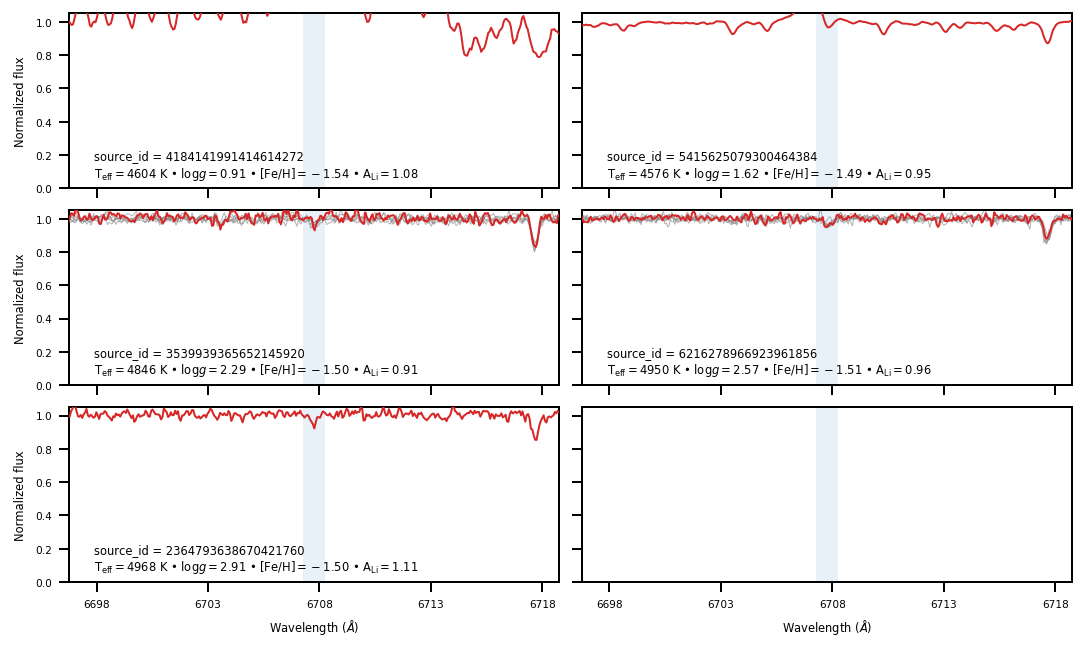

In [89]:
def teff_log_feh_box(star):
    teff_logg_idx = ((np.abs(galah_idr3['teff']-star['teff']) < 50) &
                     (np.abs(galah_idr3['logg']-star['logg']) < 0.2) &
                     (np.abs(galah_idr3['fe_h']-star['fe_h']) < 0.03) &
                     (np.abs(galah_idr3['alpha_fe']-star['alpha_fe']) < 0.05) &
                     (np.abs(galah_idr3['vbroad']-star['vbroad']) < 5) &
                     (galah_idr3['snr_c2_iraf'] > 20) &
                     (galah_idr3['sobject_id'] != star['sobject_id']))
    return teff_logg_idx

norm = mpl.colors.Normalize(vmin=-1, vmax=1.5)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def li_colour(a_li):
#     return [0.5, 0.5, 0.5]
    if np.isnan(a_li):
        return [0.5, 0.5, 0.5]
    else:
        return m.to_rgba(a_li)

#Normal metallicity
# star_list = [160519003601146,
#              160517000101393,
#              160522004101048,
#              170531003801318,
#              170517001801119,
#              151110004201355]

#feh_h -0.5
# star_list = [160531004101123,
#              171003002101124,
#              170506005401154,
#              140413002701201,
#              170408003501011,
#              171003003101157]

#fe_h -1.0
# star_list = [170602005701018,
#              160327006101287,
#              161212004601253,
#              160916001801260,
#              171101001201372,
#              170110002101161]

#fe_h -1.5
star_list = [171102001601153,
             160522002102389,
             170508002601067,
             170512001801366,
             171027001601375,
             161228002501383]

sns.set_context("paper", font_scale=0.6)
fig, axes = plt.subplots(nrows=3,
                         ncols=2,
                         figsize=(7.5, 4.5), sharex=True, sharey=True)

for li_star_count, sobject_id in enumerate(star_list):
    star_of_interest_idx = (galah_idr3['sobject_id'] == sobject_id) & useful_giants_idx
    try:
        star = galah_idr3[star_of_interest_idx][0]
    except IndexError:
        continue
    ax = axes.flatten()[li_star_count]
    
    teff_logg_idx = teff_log_feh_box(star) & useful_giants_idx & ~li_rich_idx
    print(star['sobject_id'], li_star_count, np.sum(teff_logg_idx), star['teff'])
    if np.sum(teff_logg_idx) > 0:
        random_ten_indices = np.random.choice(range(np.sum(teff_logg_idx)), size=np.min([np.sum(teff_logg_idx), 10]), replace=False)
        teff_logg_box = galah_idr3[teff_logg_idx][random_ten_indices]
        for star_count, comp_star in enumerate(teff_logg_box):
            spec_plotting(ax, comp_star, 3, dict(lw=0.5, alpha=0.6, color=[0.5, 0.5, 0.5], zorder=1))
    spec_plotting(ax, star, 3, dict(lw=1.0, alpha=1.0, color='C3', zorder=100)) #li_colour(star['a_li'])
#     for line in [6703.576, 6705.105, 6707.76,  6710.323, 6713.044]: #6707.98,
#         

    title_str = ""
    teff_str = "\mathrm{T}_\mathrm{eff}"
    logg_str = "\log g"
    feh_str = "\mathrm{[Fe/H]}"
    ali_str = "\mathrm{A}_\mathrm{Li}"
    title_full = [#f"{np.sum(teff_logg_idx)} comparisons\n",
                  f"source_id = {star['source_id']}\n",
                  f"${teff_str}={star['teff']:0.0f}$ K • ",
                  f"${logg_str}={star['logg']:0.2f}$ • ",
                  f"${feh_str}={star['fe_h']:0.2f}$ • ",
                  f"${ali_str}={star['a_li']:0.2f}$"]
    for extra_str in title_full:
        title_str += extra_str
    ax.annotate(title_str,
                xy=(6697.9,0.07), xycoords='data')
ax.set_xticks(np.arange(6690+3, 6720+4, 5))
ax.set_xlim(6707.76-11, 6707.76+11)
ax.set_ylim(0, 1.05)

[ax.axvspan(6707.76-0.5,6707.76+0.5, alpha=0.1, color='C0', lw=0) for ax in axes.flatten()]
[ax.set_xlabel("Wavelength ($\AA$)") for ax in axes[-1,:]]
[ax.set_ylabel("Normalized flux") for ax in axes[:,0]]

fig.tight_layout()
plt.savefig(f"../paper/figures/comparison_spec_plots_-1.5.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()



/Users/jeffreysimpson/anaconda3/envs/snowflakes/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


170115002701208 0 0 4675.251
KeyError on /Users/jeffreysimpson/ownCloud/GALAH_hdf5/obs/reductions/Iraf_5.3/170115/170115_com.hdf5
170115002701208 Missing file?


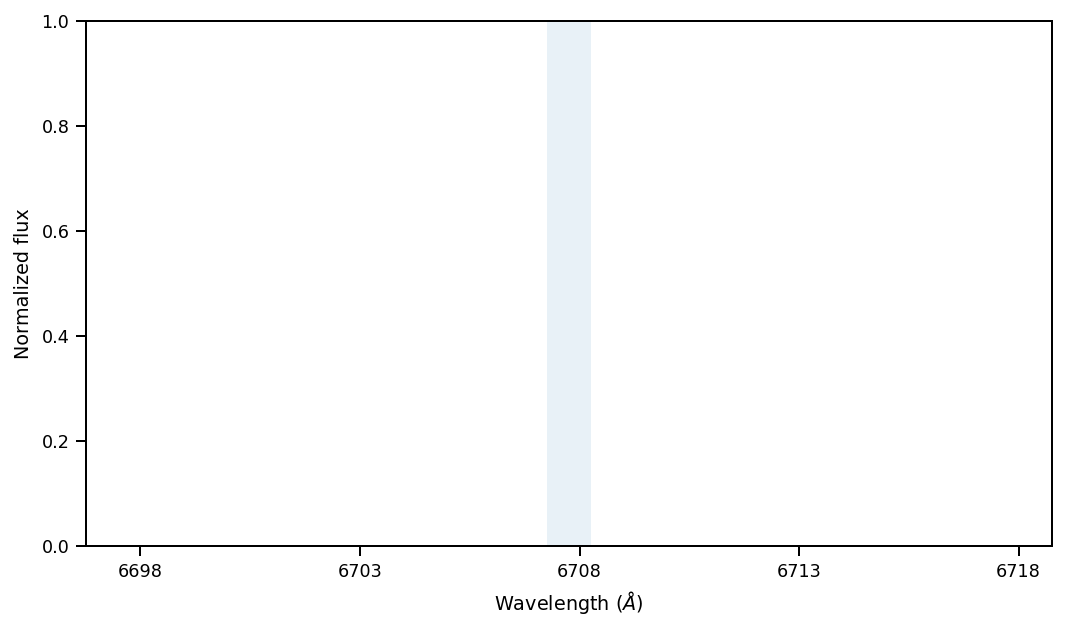

In [77]:
def teff_log_feh_box(star):
    teff_logg_idx = ((np.abs(galah_idr3['teff']-star['teff']) < 50) &
                     (np.abs(galah_idr3['logg']-star['logg']) < 0.2) &
                     (np.abs(galah_idr3['fe_h']-star['fe_h']) < 0.03) &
                     (np.abs(galah_idr3['alpha_fe']-star['alpha_fe']) < 0.05) &
                     (np.abs(galah_idr3['vbroad']-star['vbroad']) < 5) &
                     (galah_idr3['snr_c2_iraf'] > 20) &
                     (galah_idr3['sobject_id'] != star['sobject_id']))
    return teff_logg_idx

norm = mpl.colors.Normalize(vmin=4, vmax=40)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def li_colour(a_li):
#     return [0.5, 0.5, 0.5]
    if np.isnan(a_li):
        return [0.5, 0.5, 0.5]
    else:
        return m.to_rgba(a_li)

# star_list = [150602004401158,
#              160519004601118,
#              170507007201193,
#              170905001601009,
#              150607004601371,
#              150108002201367,
# #              160723002001203,
#             ]
star_list = [170115002701208,]

sns.set_context("paper", font_scale=1.0)
fig, axes = plt.subplots(nrows=1,
                         ncols=1,
                         figsize=(7.5, 4.5), sharex=True, sharey=True)

for li_star_count, sobject_id in enumerate(star_list):
    star_of_interest_idx = (galah_idr3['sobject_id'] == sobject_id) & useful_giants_idx
    star = galah_idr3[star_of_interest_idx][0]
    ax = axes#.flatten()[li_star_count]
    
    teff_logg_idx = teff_log_feh_box(star) & useful_giants_idx & ~li_rich_idx
    print(star['sobject_id'], li_star_count, np.sum(teff_logg_idx), star['teff'])
#     if np.sum(teff_logg_idx) > 10:
#         random_ten_indices = np.random.choice(range(np.sum(teff_logg_idx)), size=10, replace=False)
#     else:
#         random_ten_indices = range(np.sum(teff_logg_idx))
#     teff_logg_box = galah_idr3[teff_logg_idx][random_ten_indices]
#     for star_count, comp_star in enumerate(teff_logg_box):
#         spec_plotting(ax, comp_star, 3, dict(lw=0.5, alpha=0.6, color=[0.5, 0.5, 0.5], zorder=1))
#         if star_count > 10:
#             break
    spec_plotting(ax, star, 3, dict(lw=1.0, alpha=1.0, color=li_colour(star['vbroad']), zorder=100)) #
#     for line in [6703.576, 6705.105, 6707.76,  6710.323, 6713.044]: #6707.98,
#         

#     title_str = ""
#     teff_str = "\mathrm{T}_\mathrm{eff}"
#     logg_str = "\log g"
#     feh_str = "\mathrm{[Fe/H]}"
#     ali_str = "\mathrm{A}_\mathrm{Li}"
#     title_full = [#f"{np.sum(teff_logg_idx)} comparisons\n",
#                   f"source_id = {star['source_id']}\n",
#                   f"${teff_str}={star['teff']:0.0f}$ K • ",
#                   f"${logg_str}={star['logg']:0.2f}$ • ",
#                   f"${feh_str}={star['fe_h']:0.2f}$ • ",
#                   f"${ali_str}={star['a_li']:0.2f}$"]
#     for extra_str in title_full:
#         title_str += extra_str
#     ax.annotate(title_str,
#                 xy=(6697.9,0.07), xycoords='data')
ax.set_xticks(np.arange(6690+3, 6720+4, 5))
ax.set_xlim(6707.76-11, 6707.76+11)
# ax.set_ylim(0, 1.05)

# [ax.axvspan(6707.76-0.5,6707.76+0.5, alpha=0.1, color='C0', lw=0) for ax in axes.flatten()]
# [ax.set_xlabel("Wavelength ($\AA$)") for ax in axes[-1,:]]
# [ax.set_ylabel("Normalized flux") for ax in axes[:,0]]

ax.axvspan(6707.76-0.5,6707.76+0.5, alpha=0.1, color='C0', lw=0)
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Normalized flux")

fig.tight_layout()
# plt.savefig(f"../paper/figures/comparison_spec_plots.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()




In [63]:
galah_idr3[galah_idr3['sobject_id'] == sobject_id]

FITS_rec([('07542864-4941082', 151231003201002, 5517141785302294912, 3974, '10k_61_lbol', 'free', 0, 6632.5103, 62.32222642, 2.2668843, 5000., 2.8907683, 0.1490314, 0.08803115, 3., -1.6164703, 0.06531781, 0.01389208, 0, -1.3989508, 0.06512976, 0.01404628, -0.5, 1.7262828, nan, 34.787605, 2.09070927, 0.4799449, nan, 2.35446, nan, 144.72011, nan, 0.500004, nan, 41.40416, nan, nan, nan, 0.03, 63.25222, nan, nan, nan, nan, nan, nan, nan, 0.85431131, 0.06011154, 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.45788628, 0.03197627, 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.29371067, 0.0386575, 1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 118.61933211, 0.03664982, -49.6856195, 0.0426817, 263.55820955, -11.02855215, 1631.8126052, 1521.4117778